In [1]:
import json

with open('cuadrante_nombres.json', 'r') as archivo:
    zonas_sismicas = json.load(archivo)

1. Orán, Argelia (Coordenadas: 35,-1) 	2. Mar al este de Casablanca (Coordenadas: 35,-10) 	3. Marruecos-Argelia (Coordenadas: 35,-2) 	

4. Melilla (Coordenadas: 35,-3) 	5. Hoceima, Marruecos (Coordenadas: 35,-4) 	6. Chechaouene, Marruecos (Coordenadas: 35,-5) 	

7. Kenitra, Marruecos (Coordenadas: 35,-6) 	8. Mar al este de Marruecos (Coordenadas: 35,-7) 	9. Mar al este de Marruecos (Coordenadas: 35,-8) 	

10. Mar al este de Marruecos (Coordenadas: 35,-9) 	11. Muaskar, Argelia (Coordenadas: 35,0) 	12. Tiaret, Argelia (Coordenadas: 35,1) 	

13. Djelfa, Argelia (Coordenadas: 35,2) 	14. Djelfa, Argelia (Coordenadas: 35,3) 	15. M'Sila, Argelia (Coordenadas: 35,4) 	

16. Mar al sur de Almería (Coordenadas: 36,-1) 	17. Mar al sur de Portugal (Coordenadas: 36,-10) 	18. Mar de Alborán (Coordenadas: 36,-3) 	

19. Estrecho de Gibraltar (Coordenadas: 36,-5) 	20. Mar de Cádiz (Coordenadas: 36,-7) 	21. Mar al sur de Portugal (Coordenadas: 36,-8) 	

22. Mar al sur de Portugal (Coordenadas: 36,-9) 	23

Elige el número de la zona sísmica deseada (número):  100


C:\Users\Administrador\AppData\Local\Temp\1\ipykernel_988\3084414043.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie = df_cuad.resample("M").size().rename("Frecuencia").reset_index()


Has elegido: Córdoba con coordenadas 37,-4
                 Generalized Linear Model Regression Results                  
Dep. Variable:             Frecuencia   No. Observations:                  370
Model:                            GLM   Df Residuals:                      368
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -110.32
Date:                Sun, 18 May 2025   Deviance:                       165.15
Time:                        19:05:03   Pearson chi2:                     855.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01254
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept

¿Cuántos meses futuros deseas predecir? (máx 24):  12


C:\Users\Administrador\AppData\Local\Temp\1\ipykernel_988\3084414043.py:81: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fechas_pred = pd.date_range(start=inicio_pred + pd.DateOffset(months=1), periods=n_meses, freq="M")



📍 Predicción en cuadrante 37,-4
        Fecha  Eventos_simulados  Magnitud_promedio_estimada
0  2025-06-30                  0                         NaN
1  2025-07-31                  0                         NaN
2  2025-08-31                  0                         NaN
3  2025-09-30                  0                         NaN
4  2025-10-31                  0                         NaN
5  2025-11-30                  0                         NaN
6  2025-12-31                  0                         NaN
7  2026-01-31                  0                         NaN
8  2026-02-28                  0                         NaN
9  2026-03-31                  0                         NaN
10 2026-04-30                  0                         NaN
11 2026-05-31                  1                       3.643


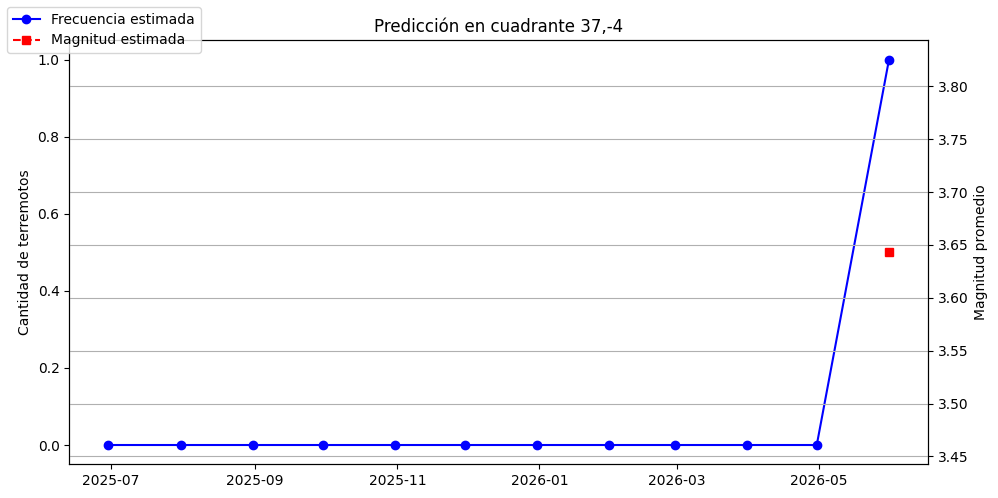

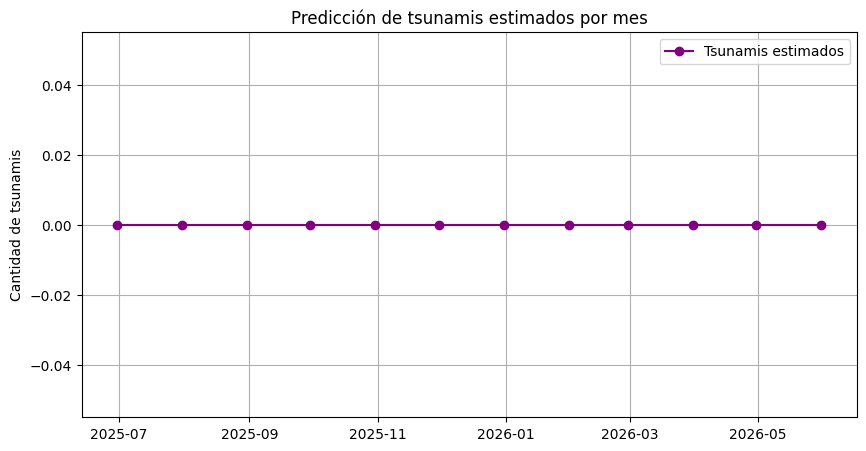

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.tseries.offsets import MonthEnd
import joblib
from statsmodels.formula.api import glm
import streamlit as st
import statsmodels.api as sm

# -----------------------------
# 1. Cargar y preparar datos
# -----------------------------
df = pd.read_csv("df_terremotos.csv")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# Crear cuadrantes 1x1
df["lat_grid"] = df["Latitud"].apply(lambda x: int(np.floor(x)))
df["lon_grid"] = df["Longitud"].apply(lambda x: int(np.floor(x)))
df["cuadrante"] = df["lat_grid"].astype(str) + "," + df["lon_grid"].astype(str)

# Seleccionar cuadrante objetivo
elementos_por_linea = 3
for i, (codigo, nombre) in enumerate(zonas_sismicas.items()):
    print(f"{i+1}. {nombre} (Coordenadas: {codigo}) ", end="\t")
    if (i + 1) % elementos_por_linea == 0:
        print()
        print()
if len(zonas_sismicas.items()) % elementos_por_linea != 0:
    print()  # Asegura una nueva línea al final si no es un múltiplo exacto

while True:
    try:
        eleccion = int(input("Elige el número de la zona sísmica deseada (número): "))
        if 1 <= eleccion <= len(zonas_sismicas):
            coordenadas = list(zonas_sismicas.keys())[eleccion - 1]
            lugar = zonas_sismicas[coordenadas]
            print(f"Has elegido: {lugar} con coordenadas {coordenadas}")
            break
        else:
            print("Por favor, elige un número de la lista.")
    except ValueError:
        print("Entrada inválida. Por favor, ingresa un número.")
cuadrante_objetivo = coordenadas

df_cuad = df[df["cuadrante"] == cuadrante_objetivo]

# Establecer 'Fecha' como índice**
df_cuad.set_index("Fecha", inplace=True)

# Crear serie mensual de frecuencia
serie = df_cuad.resample("M").size().rename("Frecuencia").reset_index()
serie["t"] = range(len(serie))  # índice temporal para la regresión

# -----------------------------
# 2. Modelo Poisson de frecuencia
# -----------------------------
if df_cuad.empty:
    print(f"No hay terremotos en el cuadrante {cuadrante_objetivo}, predicción no disponible.")
    pred_df = pd.DataFrame(columns=["Fecha", "Frecuencia estimada", "Eventos_simulados", "Magnitud_promedio_estimada"])
else:
    modelo = glm("Frecuencia ~ t", data=serie, family=sm.families.Poisson()).fit()
    print(modelo.summary())
    
    # Elegir meses a predecir
    n_meses = 0
    while n_meses > 24 or n_meses <= 0:
        n_meses = int(input("¿Cuántos meses futuros deseas predecir? (máx 24): "))
        n_meses = min(n_meses, 24)
        try:
            n_meses = int(n_meses)
            n_meses = min(n_meses, 24)
            if n_meses <= 0:
                print("Por favor, ingresa un número mayor que 0.")
            elif n_meses > 24:
                print("El número máximo de meses a predecir es 24.")
        except ValueError:
            print("Entrada inválida. Por favor, ingresa un número entero.")
    
    inicio_pred = pd.to_datetime(datetime.now().date()) + MonthEnd(0)
    fechas_pred = pd.date_range(start=inicio_pred + pd.DateOffset(months=1), periods=n_meses, freq="M")
    
    t_inicio = serie["t"].iloc[-1] + 1
    t_futuro = list(range(t_inicio, t_inicio + n_meses))
    freq_pred = modelo.predict(pd.DataFrame({"t": t_futuro}))
    
    # Consolidar predicción en DataFrame
    pred_df = pd.DataFrame({
        "Fecha": fechas_pred,
        "Frecuencia estimada": freq_pred
    })
    
    # -----------------------------
    # 3. Simular eventos por Poisson
    # -----------------------------
    np.random.seed(42)
    pred_df["Eventos_simulados"] = np.random.poisson(lam=pred_df["Frecuencia estimada"])
    
    # -----------------------------
    # 4. Predecir magnitudes por evento
    # -----------------------------
    modelo_magnitud = joblib.load("modelo_magnitud.pkl")
    
    entradas_mag = []
    for idx, row in pred_df.iterrows():
        n = int(row["Eventos_simulados"])
        for _ in range(n):
            entradas_mag.append({
                "Latitud": float(cuadrante_objetivo.split(",")[0]) + np.random.uniform(0, 1),
                "Longitud": float(cuadrante_objetivo.split(",")[1]) + np.random.uniform(0, 1),
                "Profundidad_km": np.random.uniform(1, 40),
                "Anio": row["Fecha"].year,
                "Mes": row["Fecha"].month,
                "Dia": row["Fecha"].day,
                "Hora": np.random.randint(0, 24),
                "Alerta": 1,
                "Fecha": row["Fecha"]
            })
    
    X_mag = pd.DataFrame(entradas_mag)
    
    # Separar antes de predecir
    X_mag_features = X_mag[['Latitud', 'Longitud', 'Profundidad_km', 'Anio', 'Mes', 'Dia', 'Hora', 'Alerta']]
    predicciones_mag = modelo_magnitud.predict(X_mag_features)
    
    X_mag["Magnitud"] = predicciones_mag
    
    # Promedio mensual
    magnitudes_por_mes = X_mag.groupby("Fecha")["Magnitud"].mean()
    pred_df["Magnitud_promedio_estimada"] = pred_df["Fecha"].map(magnitudes_por_mes)

    # -----------------------------
    # 4. Predecir Tsunamis por evento
    # -----------------------------
    modelo_tsunami = joblib.load("modelo_tsunami.pkl")
    
    # Preprocesar para modelo de tsunamis
    X_tsunami = X_mag[["Latitud", "Longitud", "Profundidad_km", "Anio", "Mes", "Dia", "Hora", "Alerta"]].copy()
    # Asegurarse de que todas las columnas estén presentes
    X_tsunami = X_tsunami.fillna(0)
    
    # Predecir si habrá tsunami por evento
    X_mag["Tsunami_Previsto"] = modelo_tsunami.predict(X_tsunami)
    
    # Estadísticas por mes
    tsunamis_por_mes = X_mag.groupby("Fecha")["Tsunami_Previsto"].sum()
    pred_df["Tsunamis_estimados"] = pred_df["Fecha"].map(tsunamis_por_mes).fillna(0).astype(int)
    

    # -----------------------------
    # 5. Resultado final
    # -----------------------------
    print(f"\n📍 Predicción en cuadrante {cuadrante_objetivo}")
    print(pred_df[["Fecha", "Eventos_simulados", "Magnitud_promedio_estimada"]])
    
    # -----------------------------
    # 6. Graficar
    # -----------------------------
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    ax1.plot(pred_df["Fecha"], pred_df["Eventos_simulados"], marker='o', color='blue', label="Frecuencia estimada")
    ax1.set_ylabel("Cantidad de terremotos")
    ax1.set_title(f"Predicción en cuadrante {coordenadas}")
    
    ax2 = ax1.twinx()
    ax2.plot(pred_df["Fecha"], pred_df["Magnitud_promedio_estimada"], marker='s', color='red', linestyle='--', label="Magnitud estimada")
    ax2.set_ylabel("Magnitud promedio")
    
    fig.legend(loc="upper left")
    plt.grid()
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(pred_df["Fecha"], pred_df["Tsunamis_estimados"], marker='o', color='purple', label="Tsunamis estimados")
    ax.set_title("Predicción de tsunamis estimados por mes")
    ax.set_ylabel("Cantidad de tsunamis")
    plt.grid()
    plt.legend()
    plt.show()


In [6]:
df["cuadrante"].value_counts()  # ver los más frecuentes

cuadrante
36,3      154
43,-1      80
35,-4      69
36,2       65
37,3       57
         ... 
43,4        1
40,2        1
42,-4       1
40,-10      1
37,-8       1
Name: count, Length: 109, dtype: int64

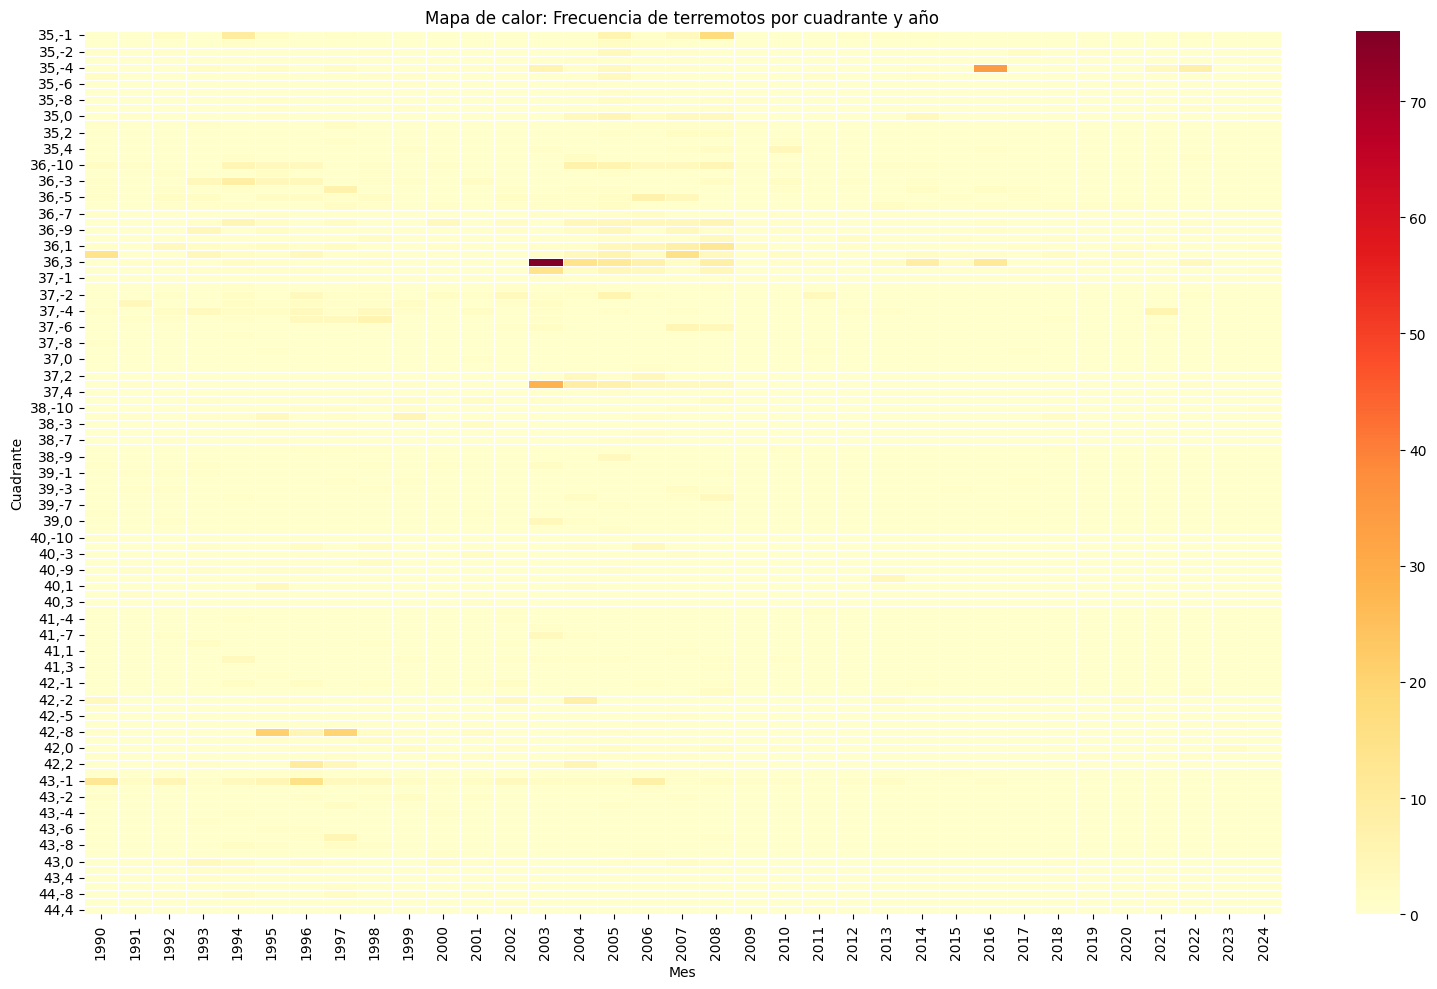

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
df_tabla = df.copy()

df_tabla['Fecha'] = pd.to_datetime(df_tabla['Fecha'])

# Crear tabla cruzada de cuadrante vs año con la frecuencia de terremotos
df_tabla['Anio'] = df_tabla['Fecha'].dt.to_period('Y')
tabla = pd.crosstab(df_tabla['cuadrante'], df_tabla['Anio'])

plt.figure(figsize=(16, 10))
sns.heatmap(tabla, cmap="YlOrRd", linewidths=.5)
plt.title("Mapa de calor: Frecuencia de terremotos por cuadrante y año")
plt.xlabel("Mes")
plt.ylabel("Cuadrante")
plt.savefig('frecuencia_terremotos.png')
plt.tight_layout()
plt.show()
